# DCGAN

In this lab, we will implement Deep Convolutional GAN (DCGAN) and train it on Fashion MNIST. Deep Convolutional GANs (DCGANs) extend the basic GAN architecture by incorporating convolutional layers, which are more effective for image data due to their ability to capture spatial hierarchies. DCGANs use convolutional and transposed convolutional layers in place of fully connected layers in both the generator and discriminator. This architecture leverages the advantages of convolutional neural networks (CNNs) to improve the quality and stability of the generated images. DCGANs follow specific design principles, such as using batch normalization, replacing pooling layers with strided convolutions, and avoiding fully connected layers to enhance training performance and output quality.

## Imports

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

## Utilities

In [ ]:
def plot_results(images, n_cols=None):
    '''Visualizes fake images'''
    display.clear_output(wait=False)

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Download and Prepare the Dataset

We will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset for this exercise. As with the case of `GAN` notebook, we will only need to create batches of the training images.

In [ ]:
# Download the training images
(X_train, _), _ = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values
X_train = X_train.astype(np.float32) / 255

# Reshape and rescale
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

BATCH_SIZE = 128

# Create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

4422102/4422102 [==============================] - 1s 0us/step


## Build the Model

In DCGANs, convolutional layers form the core of both the generator and discriminator. Let's explore the architecture and best practices used in building these layers.

### Generator

The generator takes in random noise and transforms it to match the shape of the Fashion MNIST images. The process involves:

* Feeding the input noise into a dense layer.
* Reshaping the output to have three dimensions representing (length, width, number of filters).
* Performing deconvolution using [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose), which halves the number of filters and applies a stride of `2`.
* Upsampling the features to the final size of 28 x 28 x 1 using the last deconvolution layer.

Batch normalization is applied to all layers except the final one. As a best practice, `selu` is used as the activation function for the intermediate layers, and `tanh` is used for the output layer. The model summary shows the shapes at each stage.

In [ ]:
codings_size = 32

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              206976    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        204864    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        256       
 chNormalization)                                                
                                                        

As a sanity check, let's observe the fake images produced by the untrained generator and verify the dimensions of the output.

shape of the generated batch: (16, 28, 28, 1)


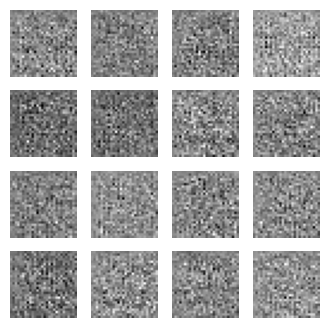

In [ ]:
# Generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, codings_size])

# Feed the batch to the untrained generator
test_image = generator(test_noise)

# Visualize sample output
plot_results(test_image, n_cols=4)

print(f'shape of the generated batch: {test_image.shape}')

### Discriminator

The discriminator uses strided convolutions to reduce the dimensionality of the input images. As a best practice, these layers are activated by [LeakyRELU](https://keras.io/api/layers/activation_layers/leaky_relu/). The output features are then flattened and fed into a single-unit dense layer with a `sigmoid` activation.

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212865 (831.50 KB)
Trainable params: 212

As done previously in the `GAN` notebook, we will combine these two subnetworks to build the complete GAN.

In [ ]:
gan = keras.models.Sequential([generator, discriminator])

## Configure the Model for Training

Since both the discriminator and GAN will continue to classify fake and real images, we will use the same settings as used before in the `GAN` notebook.

In [ ]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Train the Model

The training loop for the DCGAN will be similar to the one used in the `GAN` notebook. Let's train the model and monitor how the fake images generated by the model become increasingly realistic with each epoch.

In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:
            # Infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # Use the noise to generate fake images
            fake_images = generator(noise)

            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator (0 for the fake images 1 for the real images)
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # Ensure that the discriminator is trainable
            discriminator.trainable = True

            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # Create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # Label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)

        # Plot the fake images used to train the discriminator
        plot_results(fake_images, 16)
        plt.show()

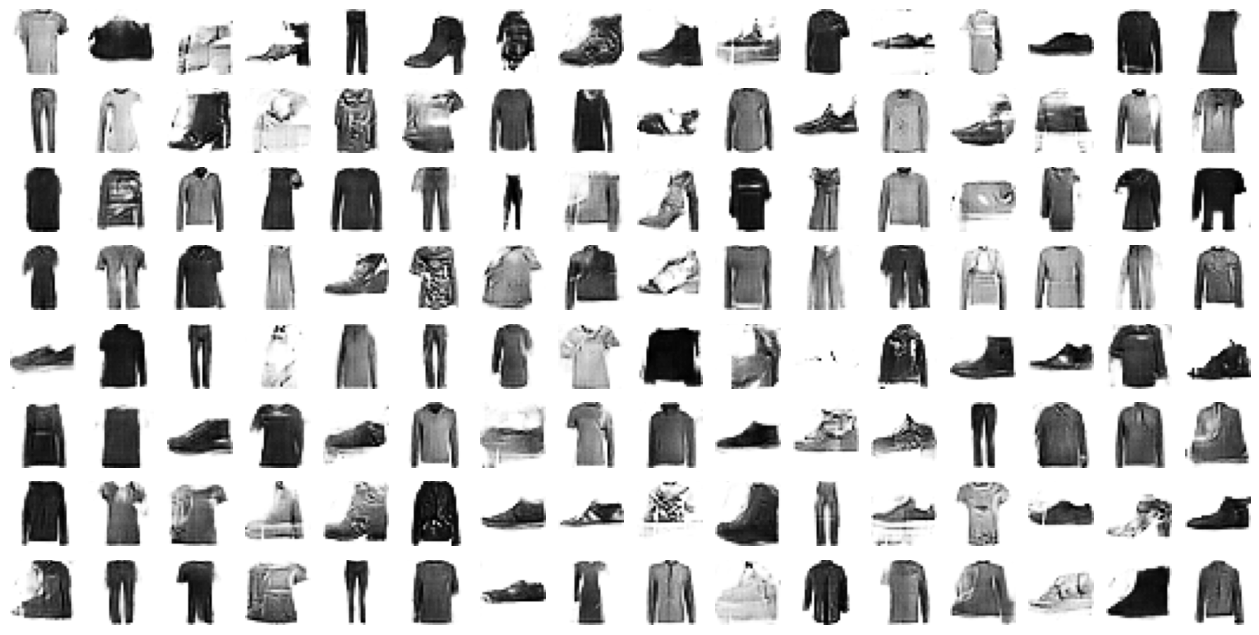

In [ ]:
train_gan(gan, dataset, codings_size, 20)